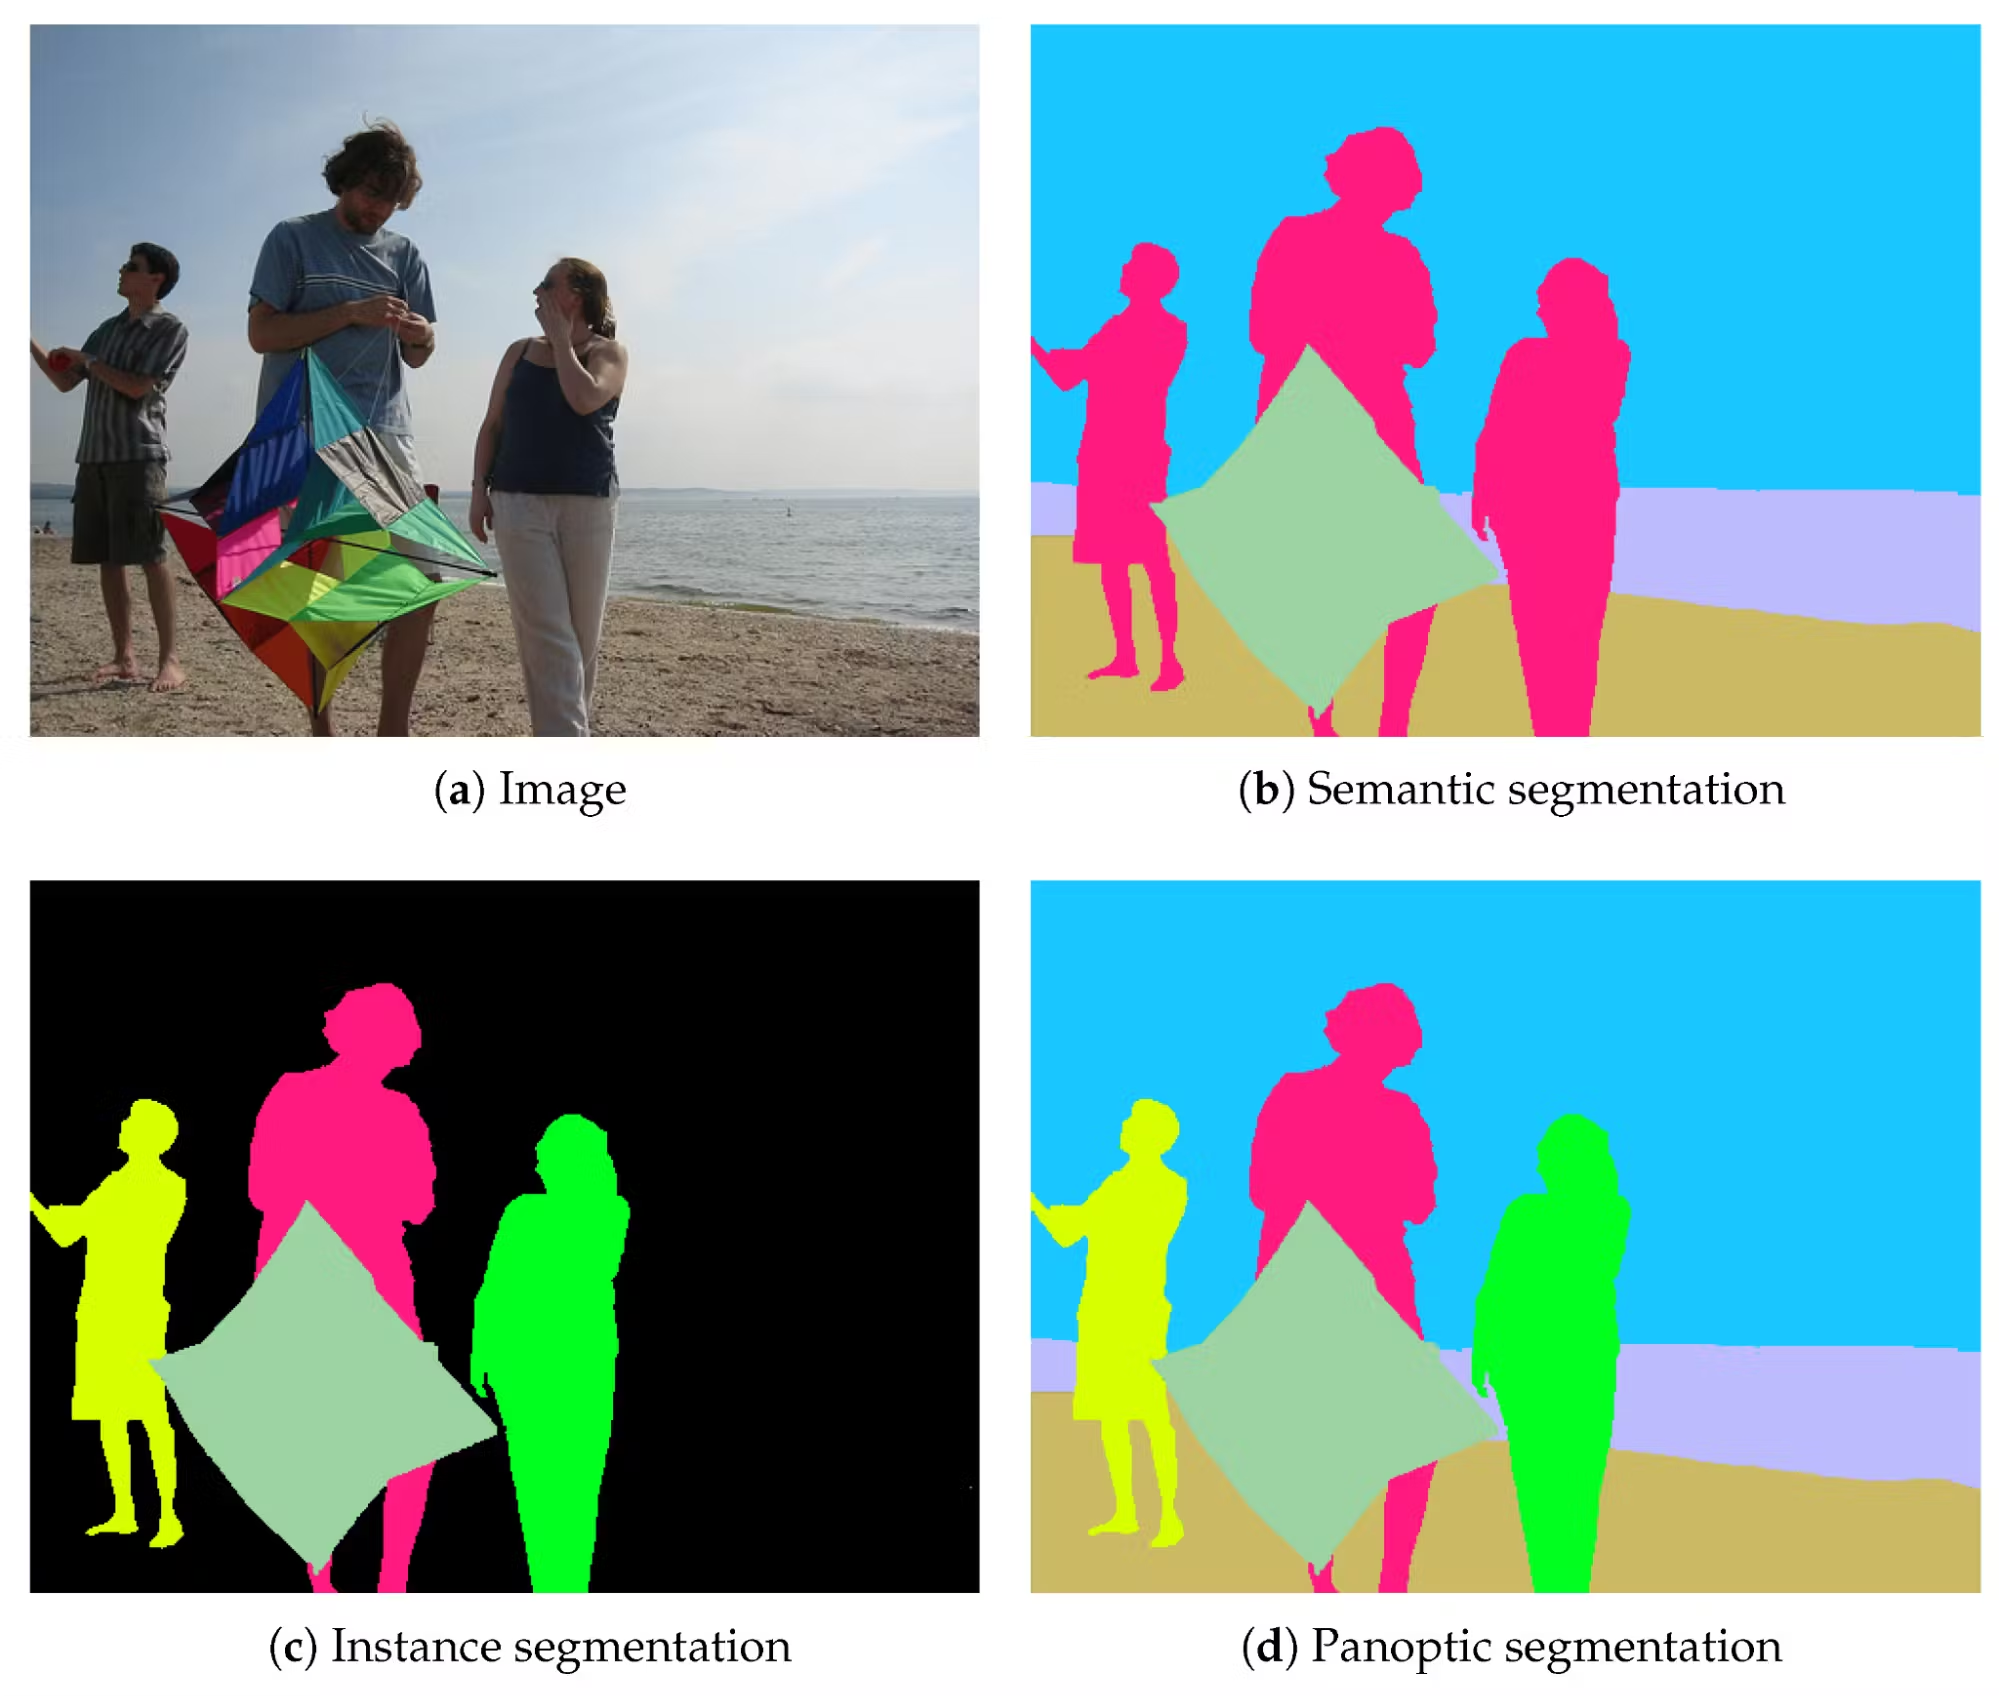

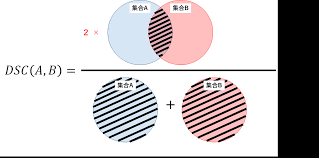

In [ ]:
def dice_loss(pred, target, smooth=.01):
    # Apply sigmoid to convert logits to probabilities
    pred = torch.sigmoid(pred)
    # Calculate intersection and union
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    # Compute Dice Coefficient
    dice = (2. * intersection + smooth) / (union + smooth)
    # Return Dice Loss
    return 1 - dice.mean()

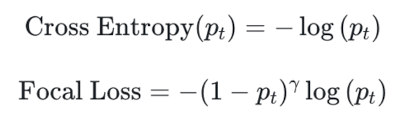

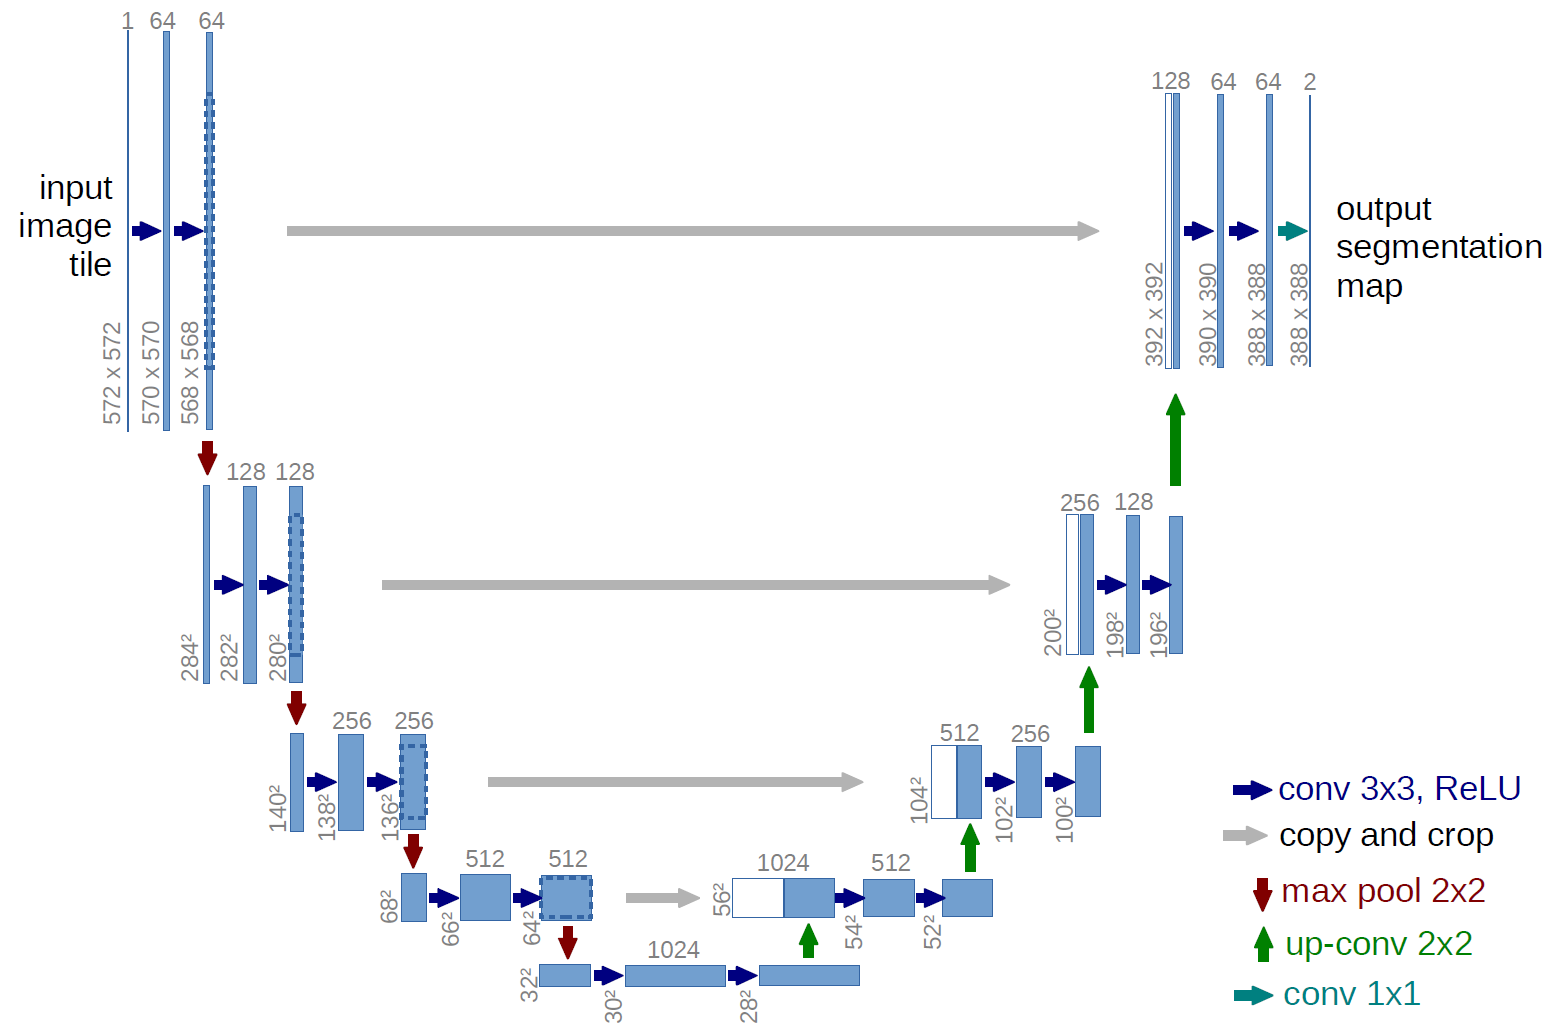

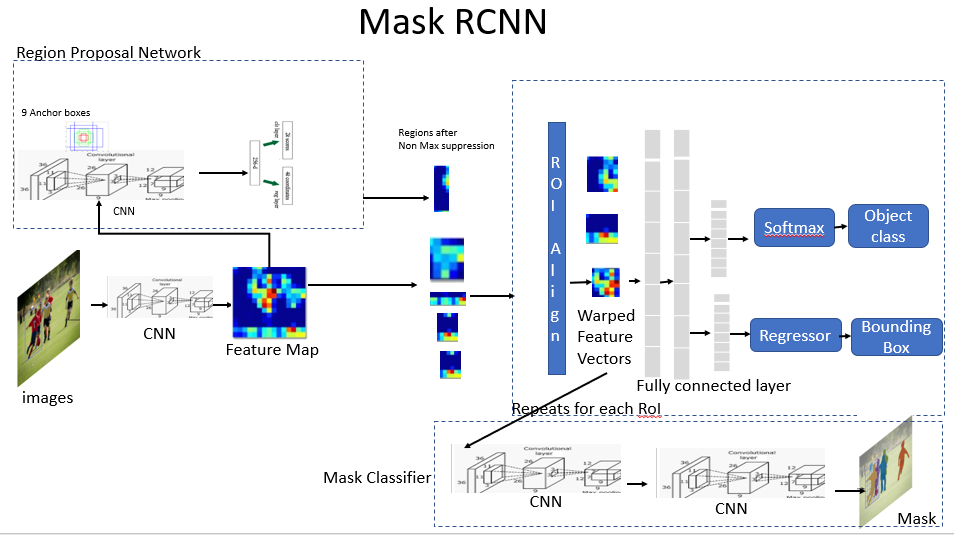

In [ ]:
# !pip install segmentation_models_pytorch
# https://www.kaggle.com/datasets/trainingdatapro/food-segmentation?select=masks_info.csv
# !unzip "archive.zip"

In [ ]:
import os
from tqdm.notebook import tqdm
import yaml
train_images = sorted(os.listdir('/content/Food Segmentation/images'))[:15]
train_labels = sorted(os.listdir('/content/Food Segmentation/masks'))[:15]

valid_images = sorted(os.listdir('/content/Food Segmentation/images'))[15:]
valid_labels = sorted(os.listdir('/content/Food Segmentation/masks'))[15:]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import gc
import cv2
import numpy as np
import segmentation_models_pytorch as smp
from torch.amp import GradScaler

(780, 1170)


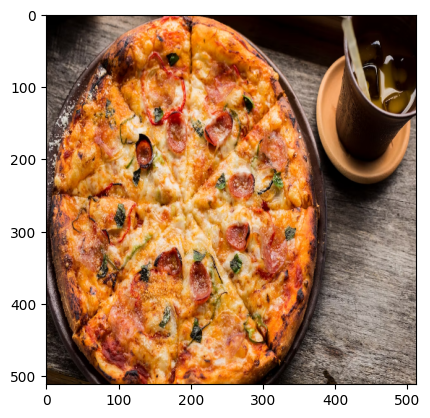

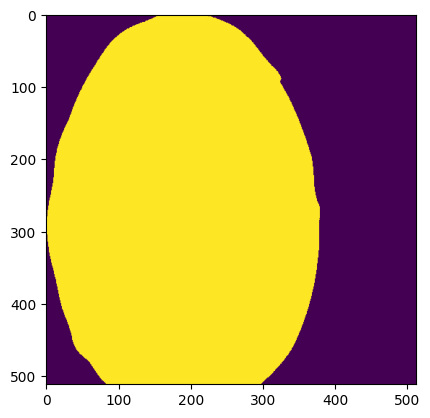

In [ ]:
i = 0
image_size = 512
img = cv2.imread('/content/Food Segmentation/images/' + train_images[i])
msk = cv2.imread('/content/Food Segmentation/masks/' + train_labels[i]).mean(2)
msk = (msk < 255).astype(np.uint8)
print(msk.shape)
img = cv2.resize(
    img, (image_size, image_size), interpolation= cv2.INTER_LINEAR)
msk = cv2.resize(
    msk, (image_size, image_size), interpolation= cv2.INTER_LINEAR)
plt.imshow(img[:, :, ::-1])
plt.show()
plt.imshow(msk)
plt.show()


In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, path_image, path_msk):

        self.path_image = path_image
        self.path_msk = path_msk
        # Resize input image
        self.image_size = 512

    def resize(self, img, interp):
        return  cv2.resize(
            img, (self.image_size, self.image_size), interpolation=interp)

    def __len__(self):
        return len(self.path_image)

    def __getitem__(self, i):

        img = cv2.imread('/content/Food Segmentation/images/' + self.path_image[i])
        msk = cv2.imread('/content/Food Segmentation/masks/' + self.path_msk[i]).mean(2)
        msk = (msk < 255).astype(np.uint8)
        msk = msk[:, :, None]
        img = cv2.resize(
            img, (self.image_size, self.image_size), interpolation= cv2.INTER_LINEAR)
        msk = cv2.resize(
            msk, (self.image_size, self.image_size), interpolation= cv2.INTER_LINEAR)

        img = (img / 255.) - 0.5
        img = np.transpose(img,(2,0,1)).astype(np.float32)
        img = torch.from_numpy(img)
        msk = torch.from_numpy(msk)

        return img, msk


In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.unet = smp.Unet('tu-maxvit_tiny_tf_512.in1k',
                             encoder_weights='imagenet',
                             classes=1,
                             decoder_channels=[256, 128, 64, 32, 16],
        )
    def forward(self, x):
        y = self.unet(x)
        return y

In [ ]:
gc.collect()
torch.cuda.empty_cache()

batch_size = 4
valid_batch_size = 4
epochs = 15
lr = 3.22e-4
clip_grad_norm = 15.28
DEVICE = 'cuda'
params_train = {'batch_size': batch_size, 'shuffle': True, 'drop_last': True, 'num_workers': 2}
params_val = {'batch_size': batch_size, 'shuffle': False, 'drop_last': False, 'num_workers': 2}


train_loader = torch.utils.data.DataLoader(Dataset(train_images, train_labels), **params_train)
val_loader = torch.utils.data.DataLoader(Dataset(valid_images, valid_labels), **params_val)

model = Model().cuda()
num_train_steps = int(len(train_loader) / batch_size  * epochs)
loss_func= smp.losses.DiceLoss(mode="binary", smooth=1.)

scaler = GradScaler('cuda')
optimizer = torch.optim.AdamW(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader) * epochs, 1e-6)
for epoch in range(epochs):
    model.train()
    average_loss = 0
    tk0 = tqdm(enumerate(train_loader), total = len(train_loader))
    for batch_number,  (img, target)  in tk0:
        optimizer.zero_grad()
        img = img.to(DEVICE)
        target = target.to(DEVICE)
        # continue
        with torch.amp.autocast('cuda'):
            outputs = model(img)
            loss = loss_func(outputs, target)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        average_loss += loss.cpu().detach().numpy()
        tk0.set_postfix(loss=average_loss / (batch_number + 1),lr = scheduler.get_last_lr()[0], stage="train", epoch = epoch)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
preds = []
imgs_list = []
target_list = []
model.eval()
average_loss = 0
with torch.no_grad():
    for batch_number,  (img, target)  in enumerate(val_loader):
        img = img.to(DEVICE)
        target = target.to(DEVICE)

        with torch.amp.autocast('cuda'):
            outputs = model(img)

        preds += [outputs.sigmoid().to('cpu').numpy()]
        imgs_list += [img.to('cpu').detach().numpy()]
        target_list += [target.to('cpu').detach().numpy()]

preds = np.concatenate(preds)[:, 0, ...]
imgs_list = np.concatenate(imgs_list)
target_list = np.concatenate(target_list)

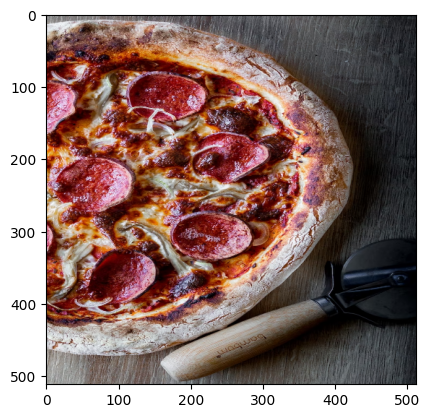

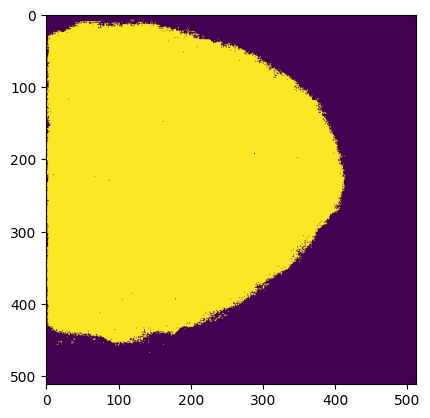

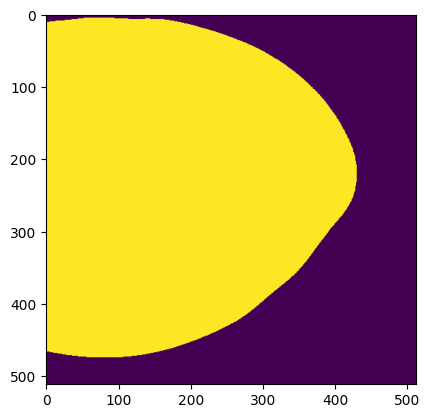

----------------------------------------------------------------------------------------------------


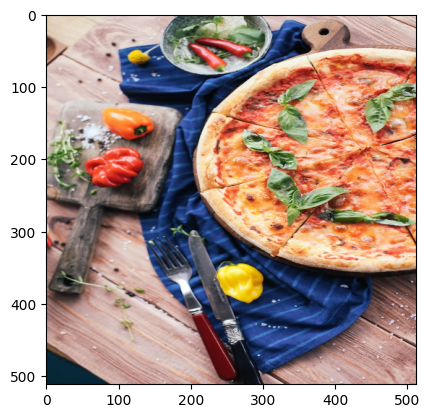

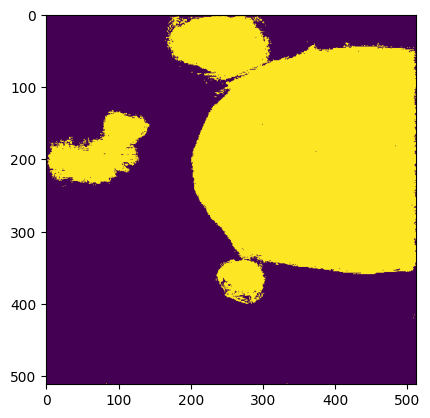

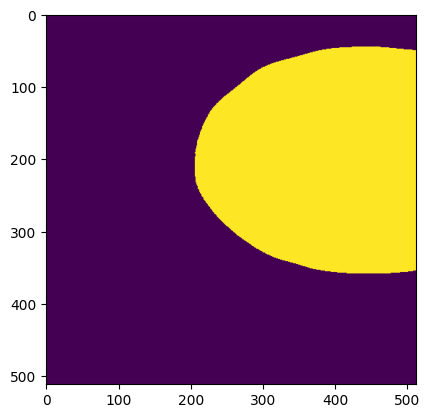

----------------------------------------------------------------------------------------------------


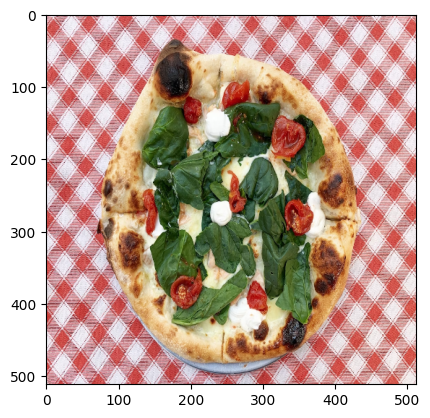

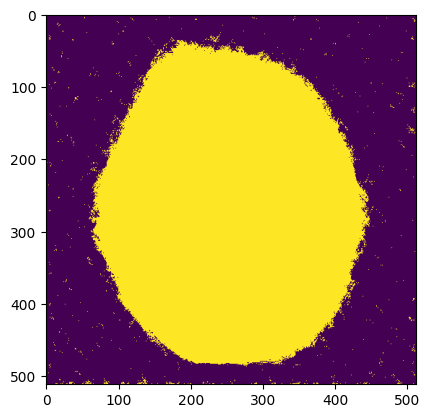

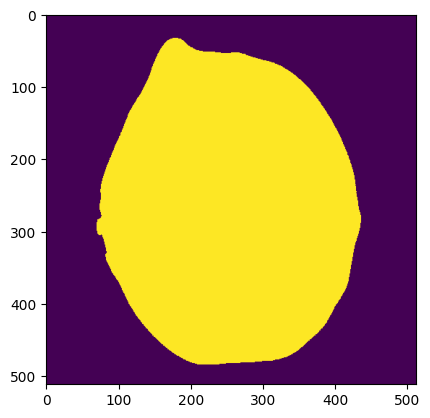

----------------------------------------------------------------------------------------------------


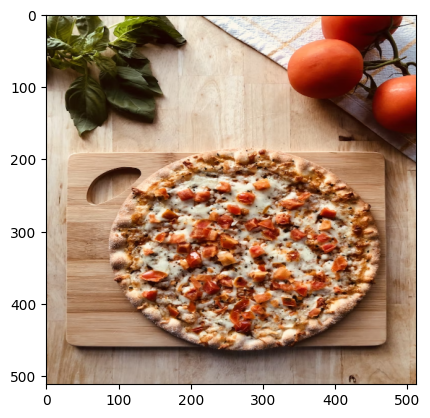

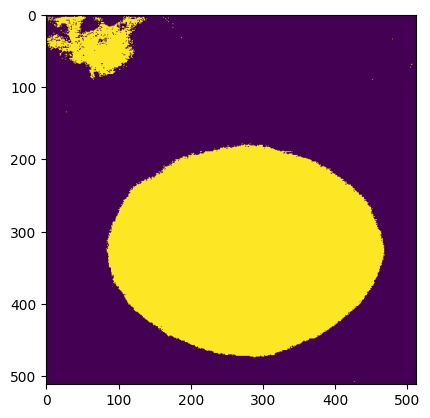

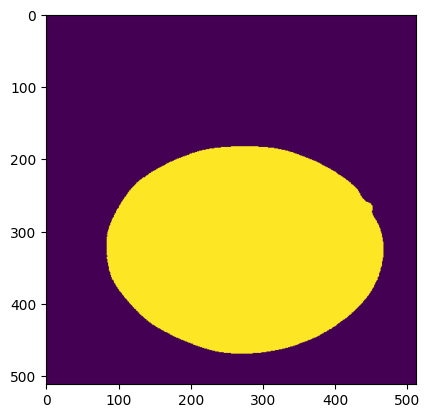

----------------------------------------------------------------------------------------------------


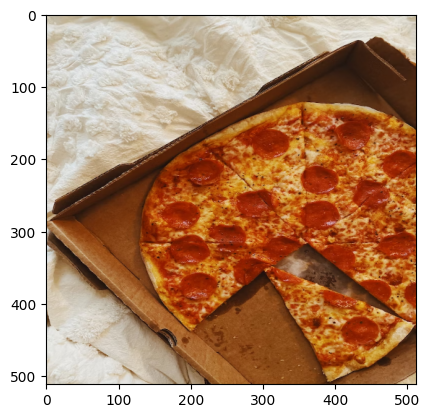

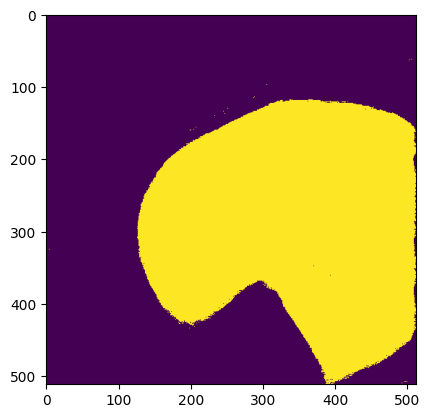

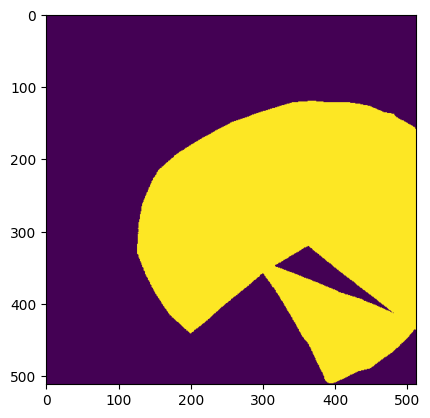

----------------------------------------------------------------------------------------------------


In [ ]:
import matplotlib.pyplot as plt
for pred, imgs, target in zip(preds, imgs_list, target_list):
    # pred = pre
    imgs = np.transpose(imgs, (1, 2, 0)) + 0.5
    imgs = imgs[:, :, ::-1]
    plt.imshow(imgs)
    plt.show()
    plt.imshow(pred > 0.5)
    plt.show()
    plt.imshow(target > 0.5)
    plt.show()

    print('-' * 100)

## TTA

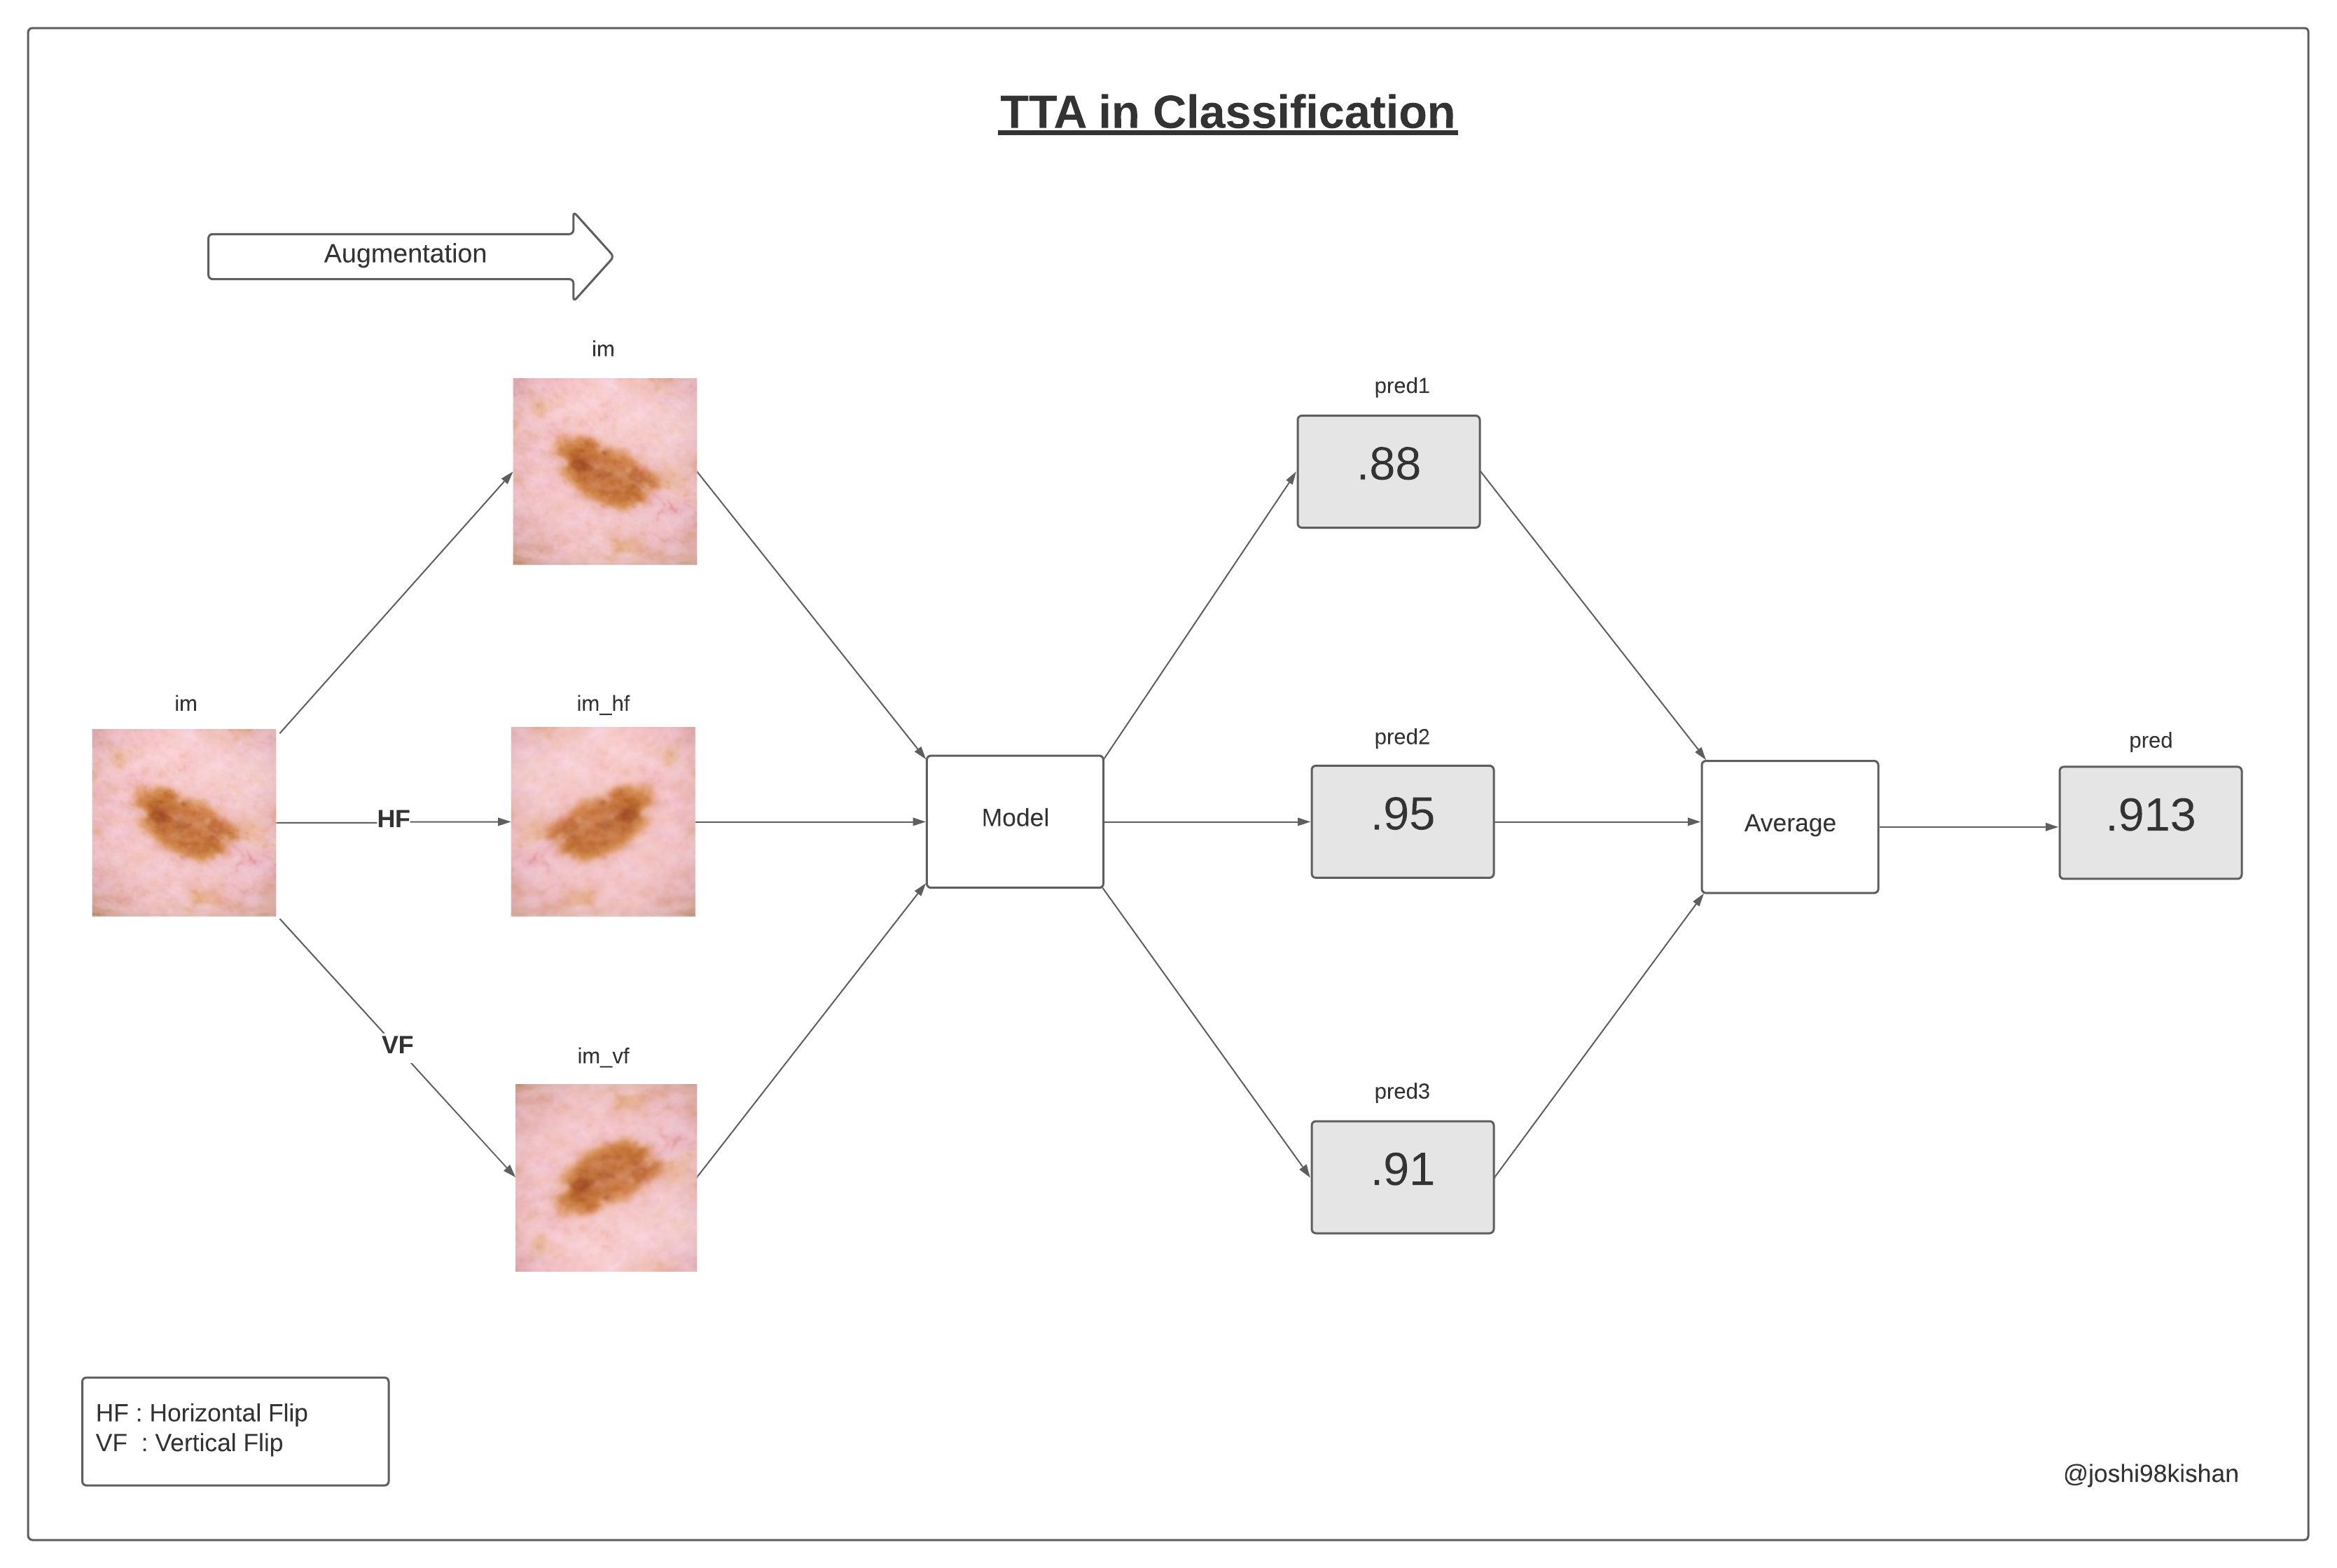

In [ ]:
# https://www.kaggle.com/competitions/blood-vessel-segmentation/discussion/475522
# https://www.kaggle.com/competitions/google-research-identify-contrails-reduce-global-warming/discussion/430618